In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# load the boston data set
from sklearn.datasets import load_boston

boston = load_boston()
data = np.concatenate([boston.data, np.expand_dims(boston.target, axis=-1)], axis=1)
df = pd.DataFrame(data=data, columns=[*list(boston.feature_names), "MEDV"])

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
# get first insights
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


# Plot Histogram of Target and Transformations

In [5]:
y = df["MEDV"].to_numpy()

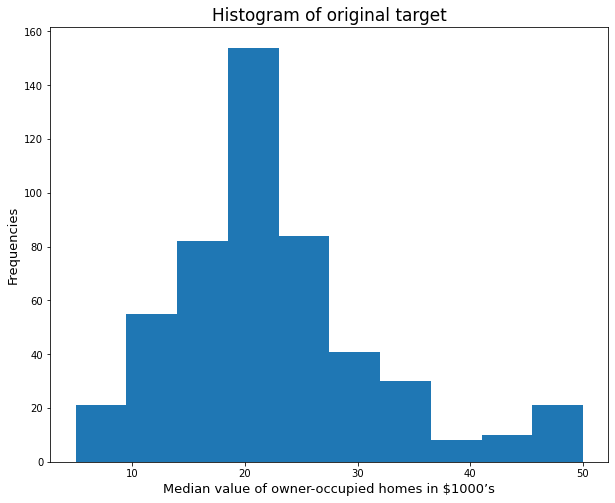

In [6]:
plt.hist(y)
plt.title("Histogram of original target", size=17)
plt.xlabel("Median value of owner-occupied homes in $1000’s", size=13)
plt.ylabel("Frequencies", size=13)
plt.show()

In [7]:
from scipy import stats

_, p = stats.normaltest(y)
print(p)

1.7583188871696095e-20


## Apply Square Root Scaling

In [8]:
y_sqrt = np.sqrt(y)

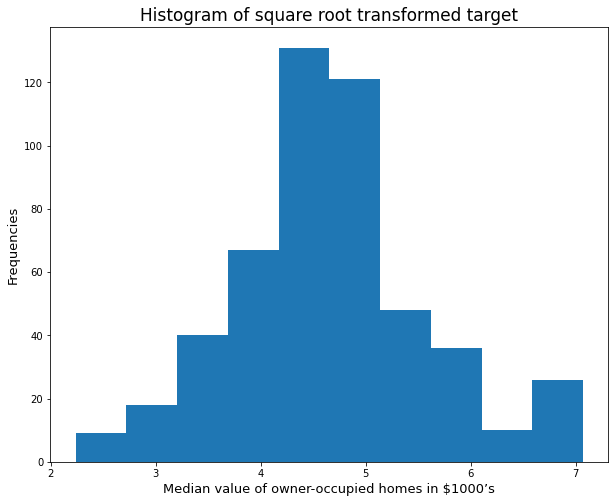

In [9]:
plt.hist(y_sqrt)
plt.title("Histogram of square root transformed target", size=17)
plt.xlabel("Median value of owner-occupied homes in $1000’s", size=13)
plt.ylabel("Frequencies", size=13)
plt.show()

In [10]:
from scipy import stats

_, p = stats.normaltest(y_sqrt)
print(p)

3.558645701429252e-05


## Apply log Scaling

In [11]:
y_log = np.log(y)

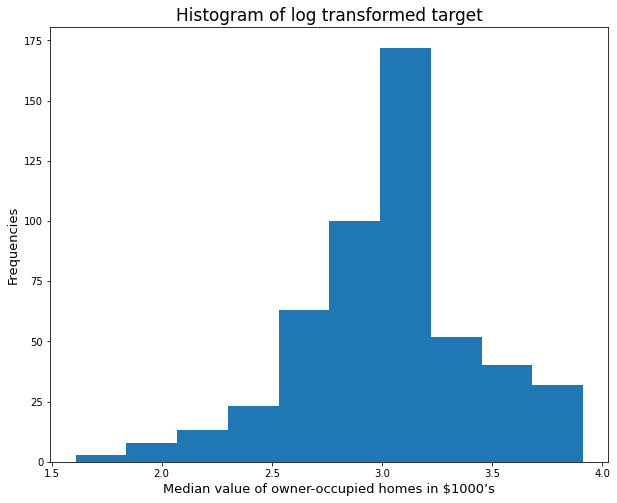

In [12]:
plt.hist(y_log)
plt.title("Histogram of log transformed target", size=17)
plt.xlabel("Median value of owner-occupied homes in $1000’s", size=13)
plt.ylabel("Frequencies", size=13)
plt.show()

In [13]:
from scipy import stats

_, p = stats.normaltest(y_log)
print(p)

0.00018245472768345196


## Apply Box Cox Scaling

In [14]:
from scipy import stats
y_bc, lambda_bc = stats.boxcox(y)

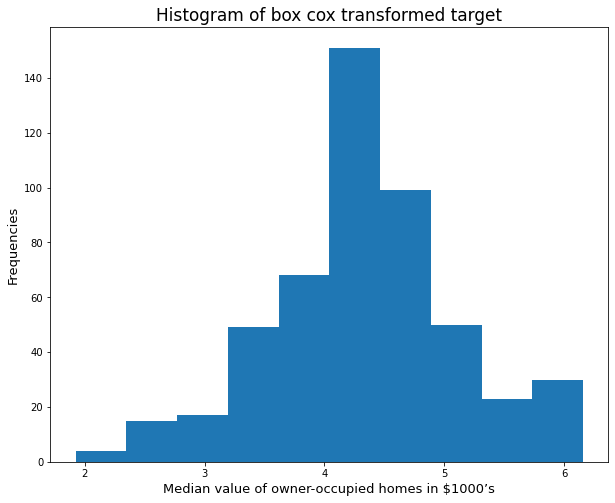

In [15]:
plt.hist(y_bc)
plt.title("Histogram of box cox transformed target", size=17)
plt.xlabel("Median value of owner-occupied homes in $1000’s", size=13)
plt.ylabel("Frequencies", size=13)
plt.show()

In [16]:
from scipy import stats

_, p = stats.normaltest(y_bc)
print(p)

0.1046886692817602


# Train Linear Regression on different Transformations and No Transformation

In [17]:
from scipy import special
from scipy import stats

class Transformer():
    '''
    This class can be used for applying transformations and inverse transformations to the target variable.
    Supported transformations:
        -> square root
        -> log
        -> box cox
    '''
    def __init__(self):
        self._lambda = 0 # init lambda -> required for box cox inverse transformation
    
    def apply_transformation(self, data_in, transform_key):
        '''
        This function applies the transformation according to transformer_key to the provided input.
        
        Args:
            data_in (np.array): Input data to transform
            transform_key (string): Key which transformation to apply (can be: square_root, log, boxcox, no_transformation)
        
        Returns: 
            data_transformed (np.array): The transformed data
        '''
        if transform_key == "no_transformation":
            data_transformed = data_in
        elif transform_key == "square_root":
            data_transformed = np.sqrt(data_in)
        elif transform_key == "log":
            data_transformed = np.log(data_in)
        elif transform_key == "boxcox":
            data_transformed, self._lambda = stats.boxcox(data_in)
        else:
            raise ValueError(f"{transform_key} is an invalid option!")
        
        return data_transformed
    
    def apply_inverse_transformation(self, data_in, transform_key):
        '''
        This function applies the inverse transformation according to transformer_key to the provided input.
        
        Args:
            data_in (np.array): Input data to transform
            transform_key (string): Key which transformation to apply (can be: square_root, log, boxcox, no_transformation)
        
        Returns: 
            data_transformed (np.array): The transformed data
        '''
        if transform_key == "no_transformation":
            data_transformed = data_in
        elif transform_key == "square_root":
            data_transformed = data_in**2
        elif transform_key == "log":
            data_transformed = np.exp(data_in)
        elif transform_key == "boxcox":
            data_transformed = special.inv_boxcox(data_in, self._lambda)
        else:
            raise ValueError(f"{transform_key} is an invalid option!")
        
        return data_transformed

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# iterate over different transformations and train model plus get error
transformations_list = [
    "no_transformation",
    "square_root",
    "log",
    "boxcox"
]

X = df.drop(columns="MEDV").to_numpy()
y = df["MEDV"].to_numpy()

# get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# use StandardScaler to scale training data and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


results_dict = {}
for transformation in transformations_list:
    
    transformer = Transformer()
    
    y_train_transformed = transformer.apply_transformation(y_train, transformation)
    
    # create linear regression model and train
    reg = LinearRegression().fit(X_train, y_train_transformed)
    
    # create predictions on test set
    preds = reg.predict(X_test)
    
    # transform back
    preds = transformer.apply_inverse_transformation(preds, transformation)
    
    # get mse and r2
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    
    # store in results dict
    results_dict[transformation] = [r2, mse]

df_results = pd.DataFrame.from_dict(results_dict, orient="index", columns=["R2-Score", "MSE"])

In [24]:
df_results

,R2-Score,MSE
no_transformation,0.711226,21.517444
square_root,0.765309,17.487534
log,0.777928,16.547235
boxcox,0.773896,16.847673
